In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

df =pd.read_csv("/content/PS_20174392719_1491204439457_log.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

from itertools import combinations as comb
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix,recall_score, roc_auc_score, accuracy_score, precision_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

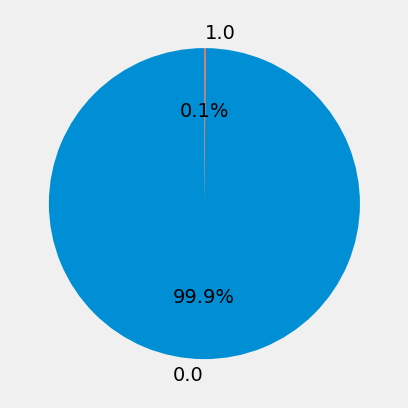

In [ ]:
fraud = df['isFraud'].value_counts()
fraud_idx = fraud.index
fraud_val = fraud.values

plt.pie(fraud_val,
        labels=fraud_idx,
        autopct='%1.1f%%',
        startangle=90)
plt.show()

In [ ]:
df['isFraud'].fillna(df['isFraud'].median(), inplace=True)


In [ ]:
df2 = resample(df,
              random_state=42,
              n_samples=10000,
              stratify=df['isFraud']).reset_index(drop=True)
df2.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,8,PAYMENT,20684.20,C1902552823,349.00,0.00,M593081598,0.00,0.00,0.0,0.0
1,1,TRANSFER,259096.62,C1769598893,37079.31,0.00,C1335050193,272725.11,353532.56,0.0,0.0
2,9,PAYMENT,12194.27,C520861695,22119.00,9924.73,M1843225023,0.00,0.00,0.0,0.0
3,9,CASH_IN,556577.68,C2038605913,3029240.84,3585818.52,C717951588,1162811.70,10306.77,0.0,0.0
4,10,PAYMENT,10992.41,C1058643795,11578.00,585.59,M771274146,0.00,0.00,0.0,0.0


In [ ]:
df2.shape

(10000, 11)

In [ ]:
df.shape

(83561, 11)

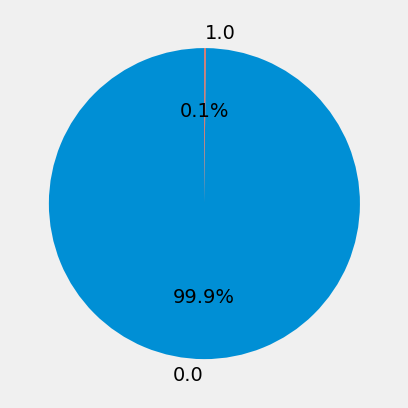

In [ ]:
fraud = df2['isFraud'].value_counts()
fraud_idx = fraud.index
fraud_val = fraud.values

plt.pie(fraud_val,
        labels=fraud_idx,
        autopct='%1.1f%%',
        startangle=90)
plt.show()

In [ ]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
step,10000.0,8.165200e+00,1.905327e+00,1.00,8.000,9.000,9.000000e+00,10.00
amount,10000.0,1.661485e+05,3.294096e+05,3.75,9684.495,44749.270,2.030313e+05,4140191.07
oldbalanceOrg,10000.0,8.908939e+05,2.735203e+06,0.00,0.000,19549.500,1.732941e+05,32575830.26
newbalanceOrig,10000.0,9.094781e+05,2.775466e+06,0.00,0.000,0.000,2.057763e+05,32922302.17
oldbalanceDest,10000.0,8.656741e+05,2.430520e+06,0.00,0.000,11439.500,5.358326e+05,29156093.99
newbalanceDest,10000.0,1.175889e+06,2.855493e+06,0.00,0.000,22769.825,1.024051e+06,31306920.44
isFraud,10000.0,1.300000e-03,3.603387e-02,0.00,0.000,0.000,0.000000e+00,1.00
isFlaggedFraud,10000.0,0.000000e+00,0.000000e+00,0.00,0.000,0.000,0.000000e+00,0.00


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
step,83561.0,8.204473e+00,1.859640e+00,1.00,8.00,9.00,9.000000e+00,10.00
amount,83561.0,1.684883e+05,3.363563e+05,0.32,9550.62,48736.24,2.056751e+05,10000000.00
oldbalanceOrg,83560.0,8.888170e+05,2.731026e+06,0.00,0.00,19873.00,1.795912e+05,33797391.55
newbalanceOrig,83560.0,9.055016e+05,2.769537e+06,0.00,0.00,0.00,2.019698e+05,34008736.98
oldbalanceDest,83560.0,8.661407e+05,2.397540e+06,0.00,0.00,19389.16,5.561267e+05,31306920.44
newbalanceDest,83560.0,1.180913e+06,2.826509e+06,0.00,0.00,36855.93,1.019467e+06,31976992.09
isFraud,83561.0,1.340338e-03,3.658630e-02,0.00,0.00,0.00,0.000000e+00,1.00
isFlaggedFraud,83560.0,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,0.00


In [ ]:
df2.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [ ]:
df2.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1, inplace=True)

In [ ]:
df2.columns

Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud'],
      dtype='object')

In [ ]:
df2.info()
df2_num = df2.select_dtypes('number').columns
df2_cat = df2.select_dtypes('object').columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            10000 non-null  int64  
 1   type            10000 non-null  object 
 2   amount          10000 non-null  float64
 3   oldbalanceOrg   10000 non-null  float64
 4   newbalanceOrig  10000 non-null  float64
 5   oldbalanceDest  10000 non-null  float64
 6   newbalanceDest  10000 non-null  float64
 7   isFraud         10000 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 625.1+ KB


In [ ]:
def outlier(x):
    q1 = np.nanpercentile(x, 25)
    q3 = np.nanpercentile(x, 75)
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr

    #identification non outlier in data
    non_outlier = []
    for num in x:
        if num >= lower_fence:
            if num <= upper_fence:
                non_outlier.append(num)
    lower_whisker = np.min(non_outlier)
    upper_whisker = np.max(non_outlier)

    #identification outlier in data
    outlier = []
    for num in x:
        if num < lower_fence:
            outlier.append(num)
        if num > upper_fence:
            outlier.append(num)

    outlier_count = len(outlier)

    print('lower_whisker: {}'.format(lower_whisker))
    print('upper_whisker: {}'.format(upper_whisker))
    print('outlier counts: {}'.format(outlier_count))

1. step


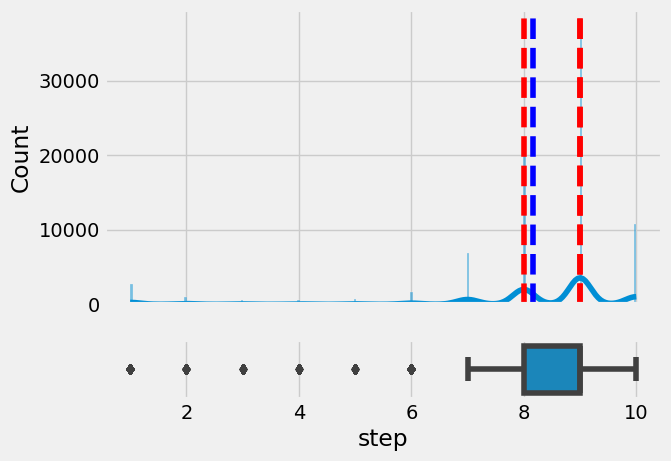

 
count    10000.000000
mean         8.165200
std          1.905327
min          1.000000
25%          8.000000
50%          9.000000
75%          9.000000
max         10.000000
Name: step, dtype: float64
 
lower_whisker: 7
upper_whisker: 10
outlier counts: 910
 
Data skewed with skew is -60.50136067484869
 
Data not normal
--------------------------------------------------
 
2. amount


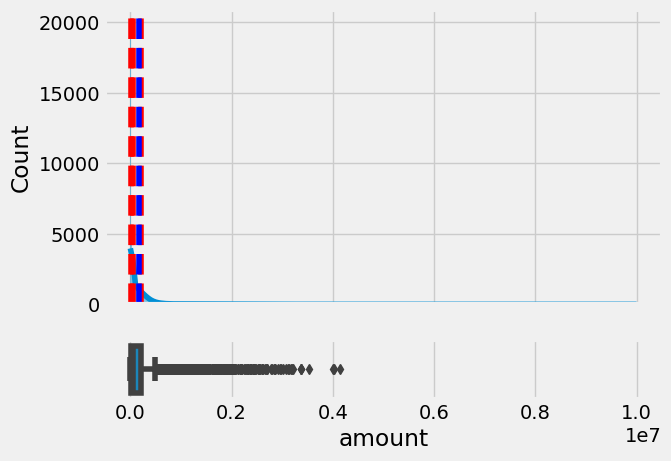

 
count    1.000000e+04
mean     1.661485e+05
std      3.294096e+05
min      3.750000e+00
25%      9.684495e+03
50%      4.474927e+04
75%      2.030313e+05
max      4.140191e+06
Name: amount, dtype: float64
 
lower_whisker: 3.75
upper_whisker: 492757.56
outlier counts: 641
 
Data skewed with skew is 83.21466157388257
 
Data not normal
--------------------------------------------------
 
3. oldbalanceOrg


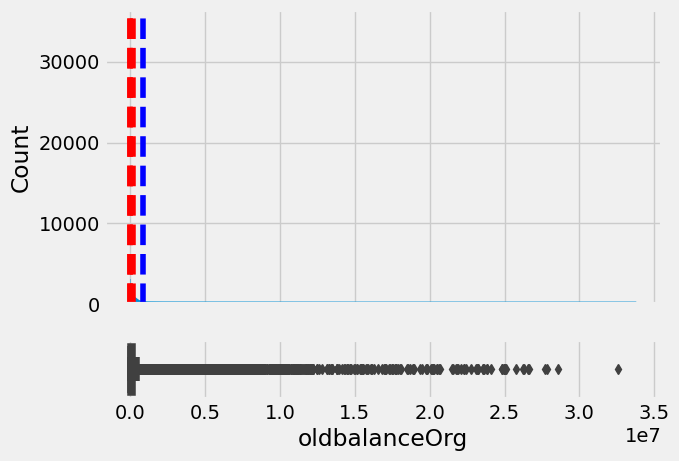

 
count    1.000000e+04
mean     8.908939e+05
std      2.735203e+06
min      0.000000e+00
25%      0.000000e+00
50%      1.954950e+04
75%      1.732941e+05
max      3.257583e+07
Name: oldbalanceOrg, dtype: float64
 
lower_whisker: 0.0
upper_whisker: 432096.9
outlier counts: 1811
 
Data skewed with skew is 83.07588435286173
 
Data not normal
--------------------------------------------------
 
4. newbalanceOrig


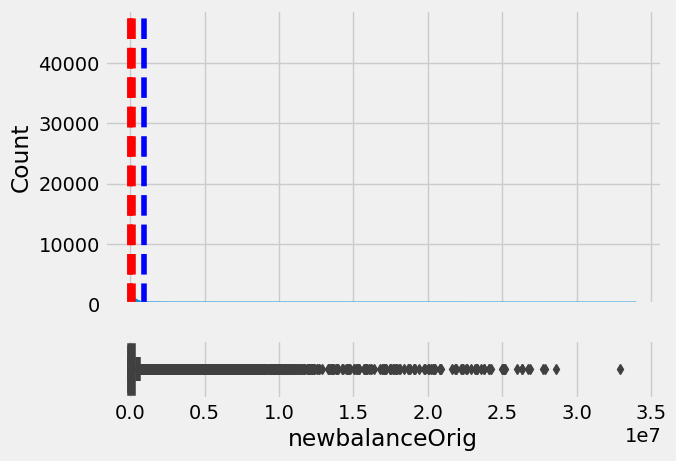

 
count    1.000000e+04
mean     9.094781e+05
std      2.775466e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.057763e+05
max      3.292230e+07
Name: newbalanceOrig, dtype: float64
 
lower_whisker: 0.0
upper_whisker: 513650.14
outlier counts: 1746
 
Data skewed with skew is 82.57791905100382
 
Data not normal
--------------------------------------------------
 
5. oldbalanceDest


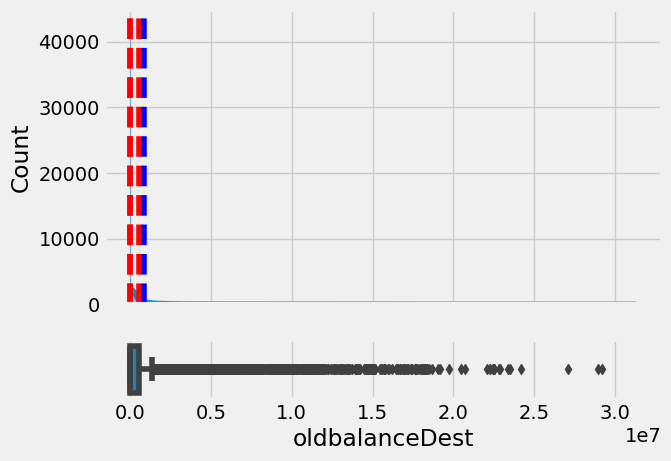

 
count    1.000000e+04
mean     8.656741e+05
std      2.430520e+06
min      0.000000e+00
25%      0.000000e+00
50%      1.143950e+04
75%      5.358326e+05
max      2.915609e+07
Name: oldbalanceDest, dtype: float64
 
lower_whisker: 0.0
upper_whisker: 1337985.61
outlier counts: 1478
 
Data skewed with skew is 83.71042411068498
 
Data not normal
--------------------------------------------------
 
6. newbalanceDest


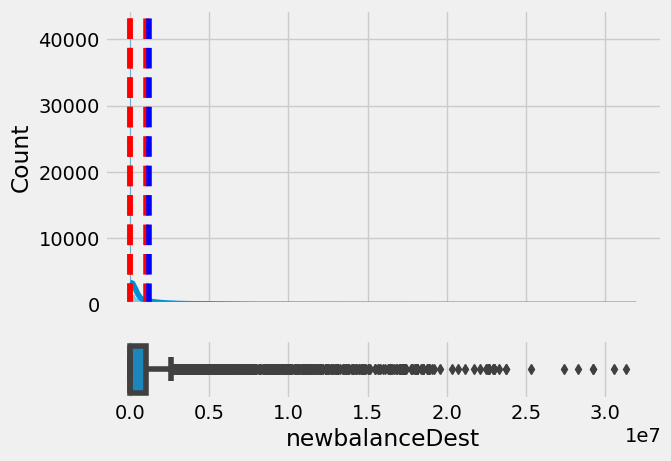

 
count    1.000000e+04
mean     1.175889e+06
std      2.855493e+06
min      0.000000e+00
25%      0.000000e+00
50%      2.276983e+04
75%      1.024051e+06
max      3.130692e+07
Name: newbalanceDest, dtype: float64
 
lower_whisker: 0.0
upper_whisker: 2560087.65
outlier counts: 1244
 
Data skewed with skew is 78.84802208903129
 
Data not normal
--------------------------------------------------
 
7. isFraud


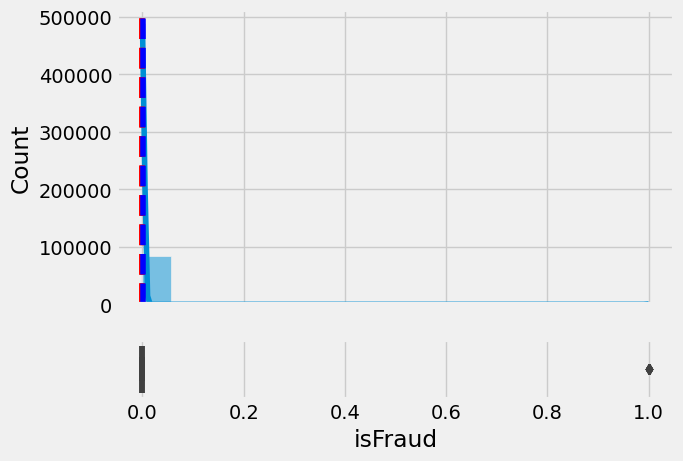

 
count    10000.000000
mean         0.001300
std          0.036034
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: isFraud, dtype: float64
 
lower_whisker: 0.0
upper_whisker: 0.0
outlier counts: 13
 
Data skewed with skew is 140.78724200790404
 
Data not normal
--------------------------------------------------
 


In [ ]:
# univariant analysis
norm_data = []
for y,x in enumerate(df2_num,1):
    print(f'{y}. {x}')
    fig, ax = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios':[5,1]})
    sns.histplot(data=df, x=x, kde=True, ax=ax[0])
    ax[0].axvline(np.nanpercentile(df2[x], 25), c='red',linestyle='--')
    ax[0].axvline(np.nanpercentile(df2[x], 50), c='red',linestyle='--')
    ax[0].axvline(np.nanpercentile(df2[x], 75), c='red',linestyle='--')
    ax[0].axvline(np.mean(df2[x]), c='blue',linestyle='--')

    sns.boxplot(data=df2, x=x, ax=ax[1])
    ax[1].set_xlabel(f'{x}')
    plt.show()

    print(' ')
    print(df2[x].describe())
    print(' ')
    outlier(df2[x])
    print(' ')
    sk, pval = st.skewtest(df2[x])
    if pval < 0.05:
        print(f'Data skewed with skew is {sk}')
    else:
        print(f'Data not skewed')
    print(' ')
    norm, pval = st.normaltest(df2[x])
    if pval < 0.05:
        print(f'Data not normal')
    else:
        print(f'Data normal')
        norm_data.append(x)
    print('-'*50)
    print(' ')

1. step - amount


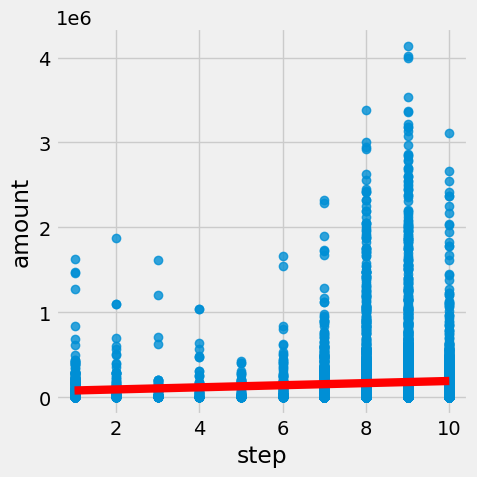

data have spearman correlation with spesification:
corr: 0.15738667724070327
pvalue: 1.7709517906824375e-56
Low corr between step and amount
 
 
2. step - oldbalanceOrg


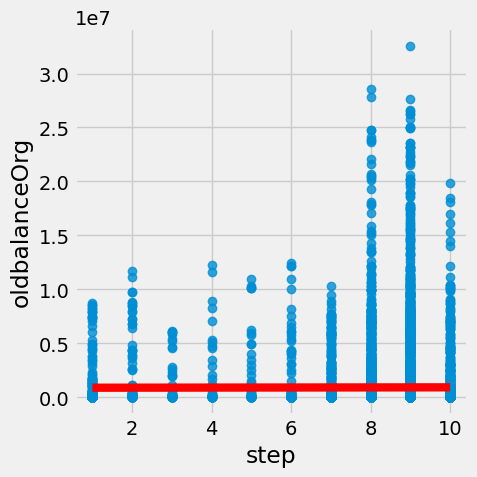

data have spearman correlation with spesification:
corr: -0.020071068745421663
pvalue: 0.04474347356523983
Low corr between step and oldbalanceOrg
 
 
3. step - newbalanceOrig


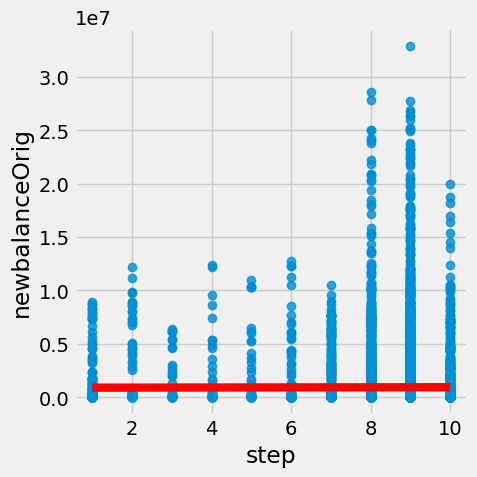

data have spearman correlation with spesification:
corr: -0.020381657484463973
pvalue: 0.04153766796231977
Low corr between step and newbalanceOrig
 
 
4. step - oldbalanceDest


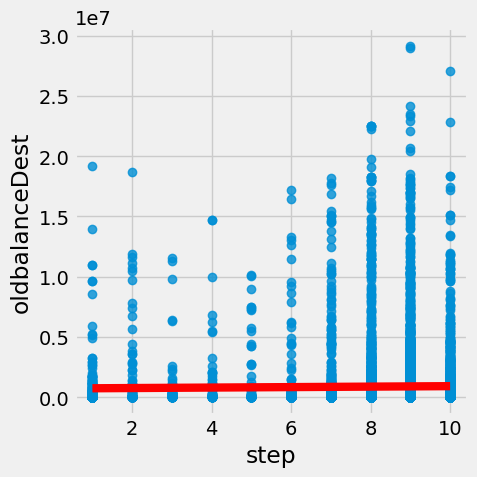

data have spearman correlation with spesification:
corr: 0.09192216393685558
pvalue: 3.2439091059397763e-20
Low corr between step and oldbalanceDest
 
 
5. step - newbalanceDest


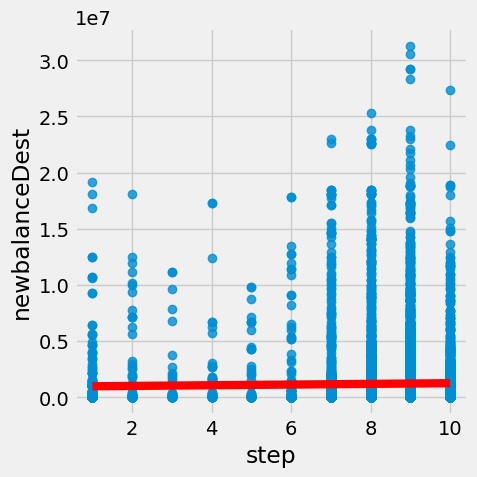

data have spearman correlation with spesification:
corr: 0.10325623224250839
pvalue: 4.0978275293628687e-25
Low corr between step and newbalanceDest
 
 
6. step - isFraud


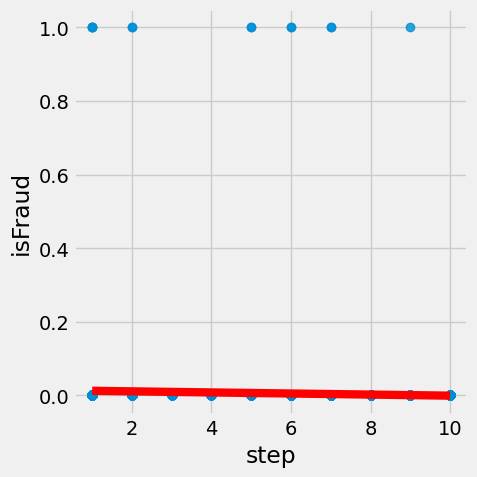

data have spearman correlation with spesification:
corr: -0.052192922957612686
pvalue: 1.7681066104304393e-07
Low corr between step and isFraud
 
 
7. amount - oldbalanceOrg


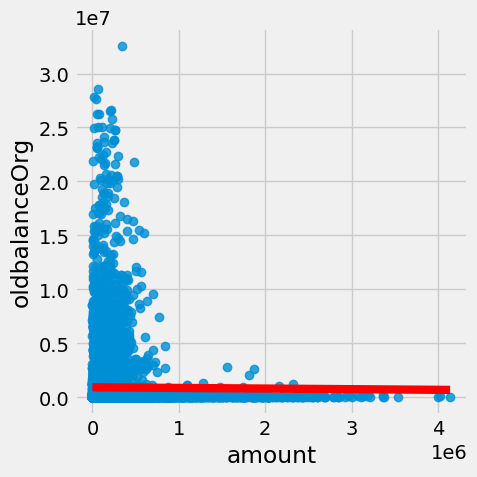

data have spearman correlation with spesification:
corr: 0.025366067680427127
pvalue: 0.011190350437120886
Low corr between amount and oldbalanceOrg
 
 
8. amount - newbalanceOrig


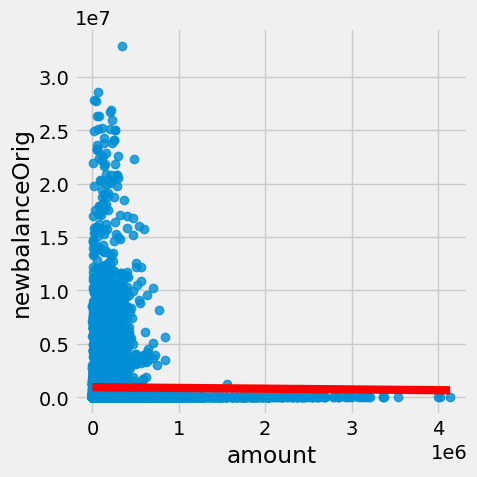

data have spearman correlation with spesification:
corr: -0.09045674200759111
pvalue: 1.2676260185747405e-19
Low corr between amount and newbalanceOrig
 
 
9. amount - oldbalanceDest


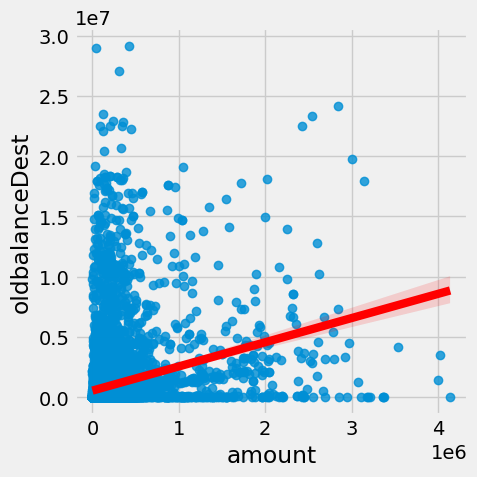

data have spearman correlation with spesification:
corr: 0.6714593265249702
pvalue: 0.0
Low corr between amount and oldbalanceDest
 
 
10. amount - newbalanceDest


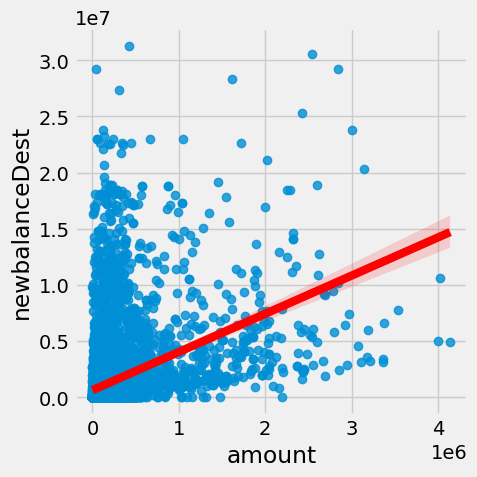

data have spearman correlation with spesification:
corr: 0.71237474695494
pvalue: 0.0
Low corr between amount and newbalanceDest
 
 
11. amount - isFraud


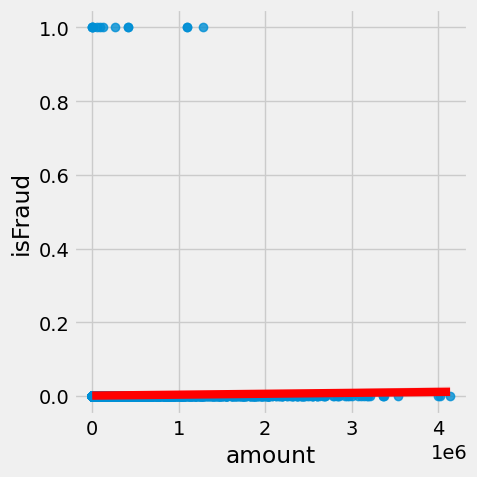

data have spearman correlation with spesification:
corr: 0.011897731926016912
pvalue: 0.23417747143383566
Low corr between amount and isFraud
 
 
12. oldbalanceOrg - newbalanceOrig


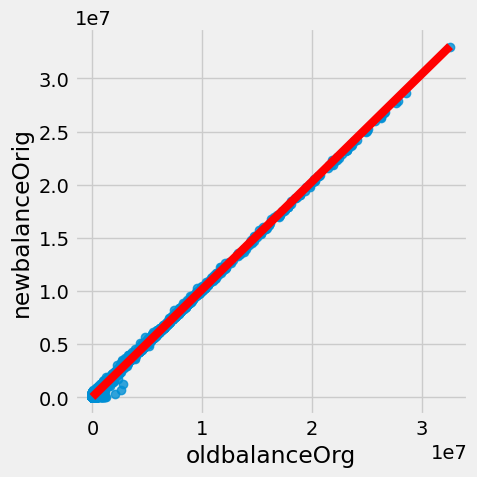

data have spearman correlation with spesification:
corr: 0.8516725931234925
pvalue: 0.0
Low corr between oldbalanceOrg and newbalanceOrig
 
 
13. oldbalanceOrg - oldbalanceDest


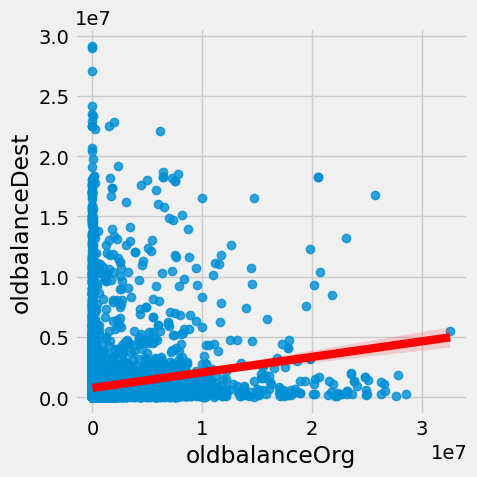

data have spearman correlation with spesification:
corr: 0.022848617218968373
pvalue: 0.0223201961191896
Low corr between oldbalanceOrg and oldbalanceDest
 
 
14. oldbalanceOrg - newbalanceDest


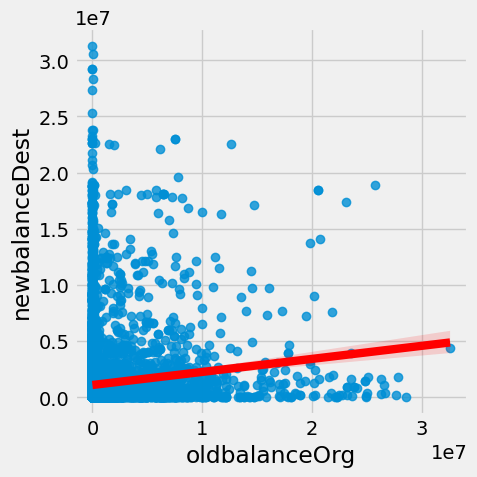

data have spearman correlation with spesification:
corr: -0.016727072473962087
pvalue: 0.09440308155569721
Low corr between oldbalanceOrg and newbalanceDest
 
 
15. oldbalanceOrg - isFraud


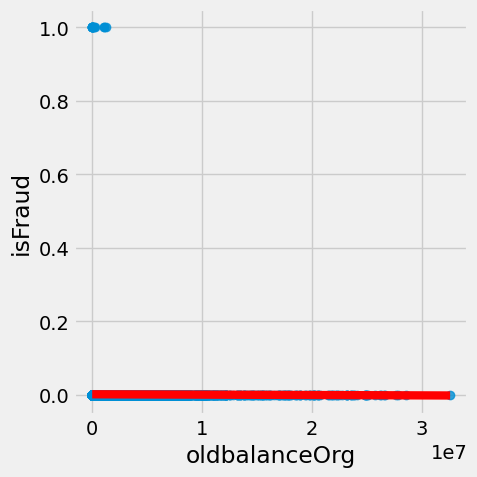

data have spearman correlation with spesification:
corr: 0.007270325875510609
pvalue: 0.4672557835629766
Low corr between oldbalanceOrg and isFraud
 
 
16. newbalanceOrig - oldbalanceDest


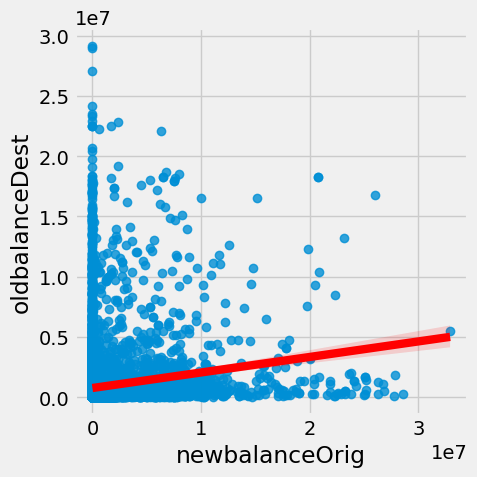

data have spearman correlation with spesification:
corr: 0.035961922260998286
pvalue: 0.0003220247170623142
Low corr between newbalanceOrig and oldbalanceDest
 
 
17. newbalanceOrig - newbalanceDest


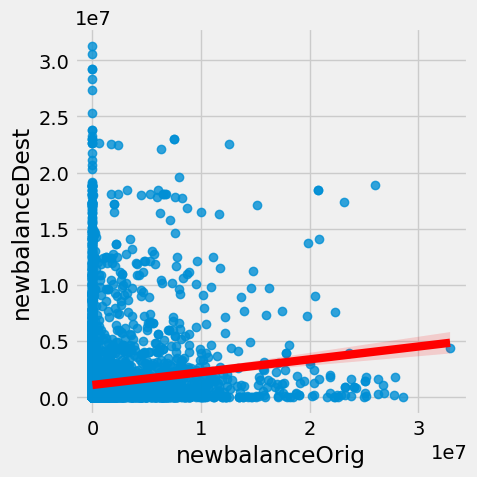

data have spearman correlation with spesification:
corr: -0.09563256220930084
pvalue: 9.332815669665334e-22
Low corr between newbalanceOrig and newbalanceDest
 
 
18. newbalanceOrig - isFraud


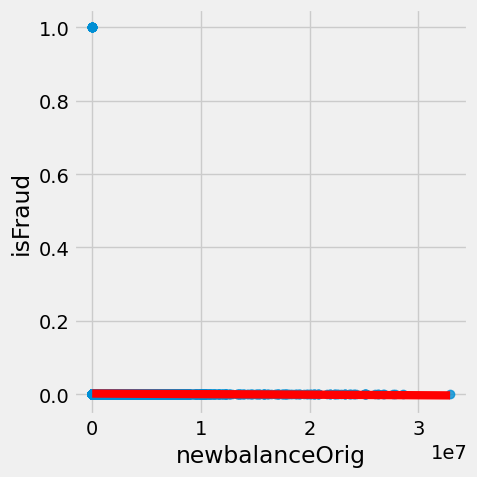

data have spearman correlation with spesification:
corr: -0.03281588645308938
pvalue: 0.0010305083182444677
Low corr between newbalanceOrig and isFraud
 
 
19. oldbalanceDest - newbalanceDest


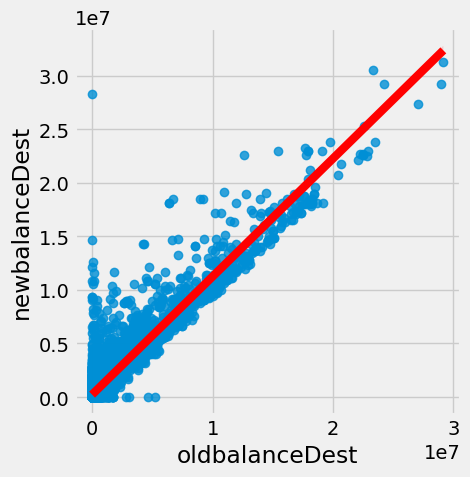

data have spearman correlation with spesification:
corr: 0.8664159525317352
pvalue: 0.0
Low corr between oldbalanceDest and newbalanceDest
 
 
20. oldbalanceDest - isFraud


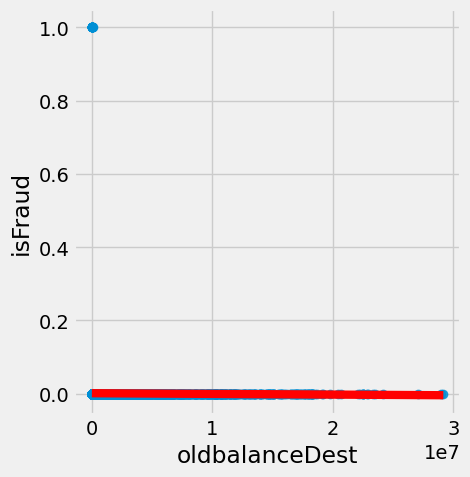

data have spearman correlation with spesification:
corr: -0.018777391540258048
pvalue: 0.060426329508799566
Low corr between oldbalanceDest and isFraud
 
 
21. newbalanceDest - isFraud


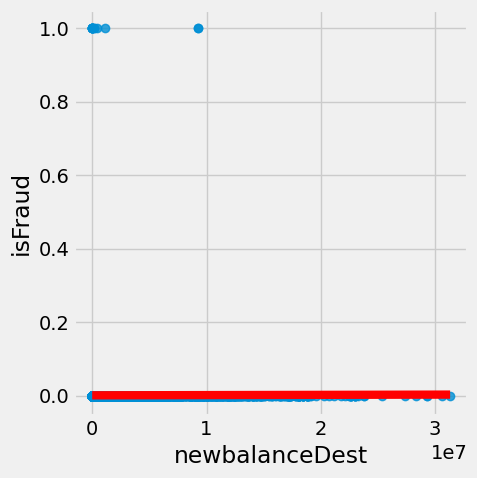

data have spearman correlation with spesification:
corr: -0.0008747258595831587
pvalue: 0.9303045531477275
Low corr between newbalanceDest and isFraud
 
 


In [ ]:
y=1
high_cor = []
low_cor = []
for col1, col2 in comb(df2_num,2):
    if (col1 != 'Credit_Score') or (col2 != 'Credit_Score'):
        plt.figure(figsize=(5,5))
        print(f'{y}. {col1} - {col2}')
        df2_na = df2.dropna()
        sns.regplot(data=df2_na, x=col1, y=col2, line_kws={'color':'red'})
        plt.tight_layout()
        plt.show()
        if (col1 in norm_data) & (col2 in norm_data):
            pear, pval1 = st.pearsonr(df2_na[col1],df2_na[col2])
            print(f'data have pearson correlation with spesification:')
            print(f'corr: {pear}')
            print(f'pvalue: {pval1}')
            if (pear > 0.8) | (pear < -0.8):
                high_cor.append([col1,col2])
                print(f'High corr between {col1} and {col2}')
            else:
                low_cor.append([col1,col2])
                print(f'Low corr between {col1} and {col2}')
        else:
            spear, pval2 = st.spearmanr(df2_na[col1],df2_na[col2])
            print(f'data have spearman correlation with spesification:')
            print(f'corr: {spear}')
            print(f'pvalue: {pval2}')
            if (spear > 0.9) | (spear < -0.9):
                high_cor.append([col1,col2])
                print(f'High corr between {col1} and {col2}')
            else:
                low_cor.append([col1,col2])
                print(f'Low corr between {col1} and {col2}')
        print(' ')

        y+=1
        print(' ')

1. isFraud - step


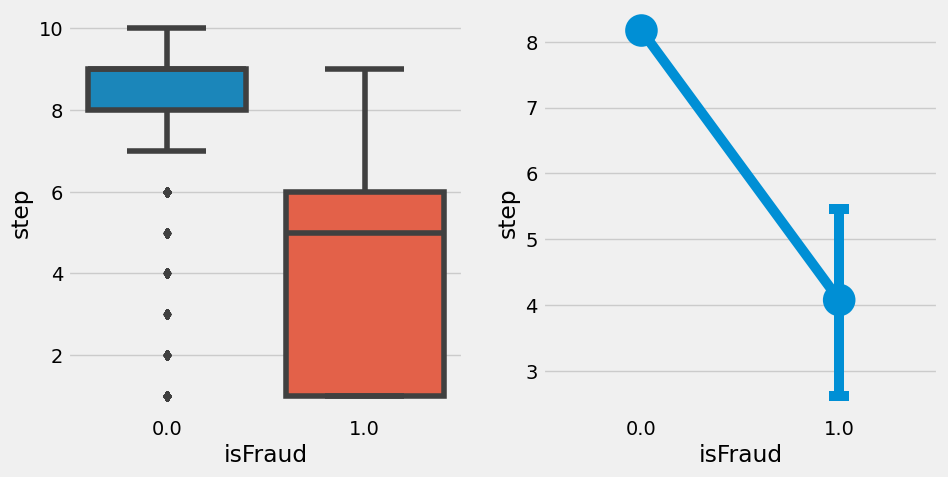

interval at column step which gets accepted is between 2.359524015861372 and 5.794322137984781
interval at column step which gets rejected is between 8.133287156711136 and 8.207756199652136
 
there is a difference between customers with Fraud and non-Fraud at feature step
 
2. isFraud - amount


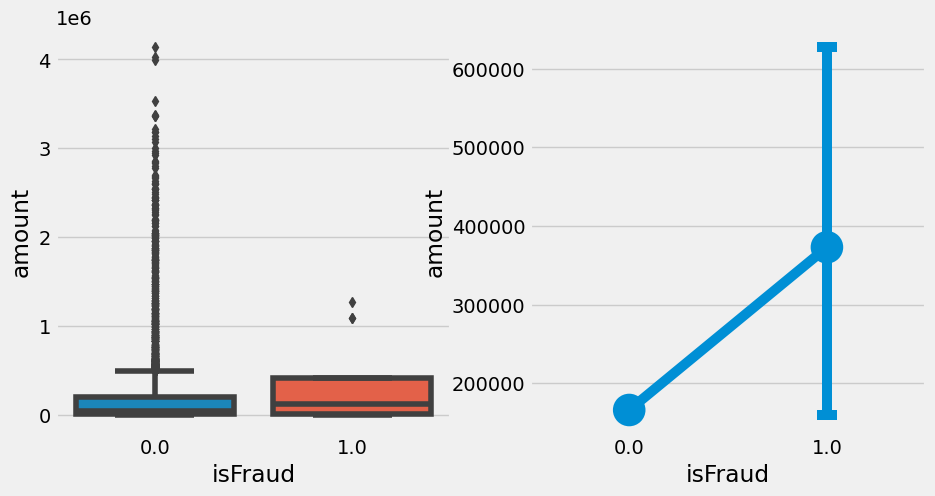

interval at column amount which gets accepted is between 88018.80992995028 and 657813.4116085113
interval at column amount which gets rejected is between 159423.4741714848 and 172335.2436156385
 
there is a difference between customers with Fraud and non-Fraud at feature amount
 
3. isFraud - oldbalanceOrg


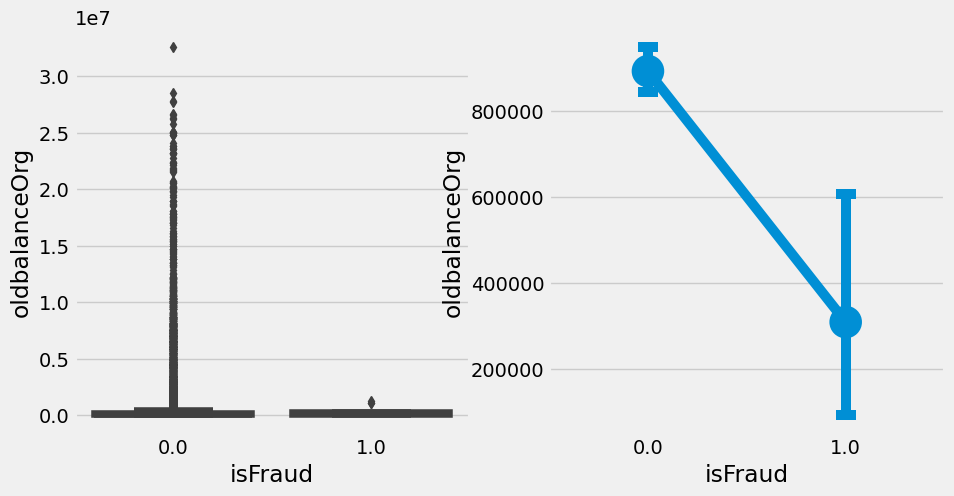

interval at column oldbalanceOrg which gets accepted is between 12441.729971595516 and 605390.0823360968
interval at column oldbalanceOrg which gets rejected is between 837968.8067110615 and 945334.1580291007
 
there is no difference between customers with Fraud and non-Fraud at feature oldbalanceOrg
 
4. isFraud - newbalanceOrig


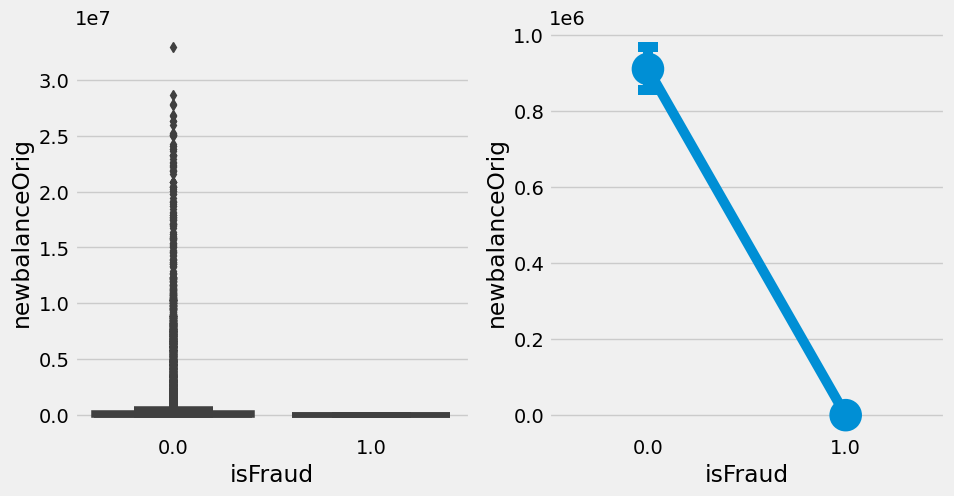

interval at column newbalanceOrig which gets accepted is between nan and nan
interval at column newbalanceOrig which gets rejected is between 856190.2658498137 and 965133.746177822
 
there is no difference between customers with Fraud and non-Fraud at feature newbalanceOrig
 
5. isFraud - oldbalanceDest


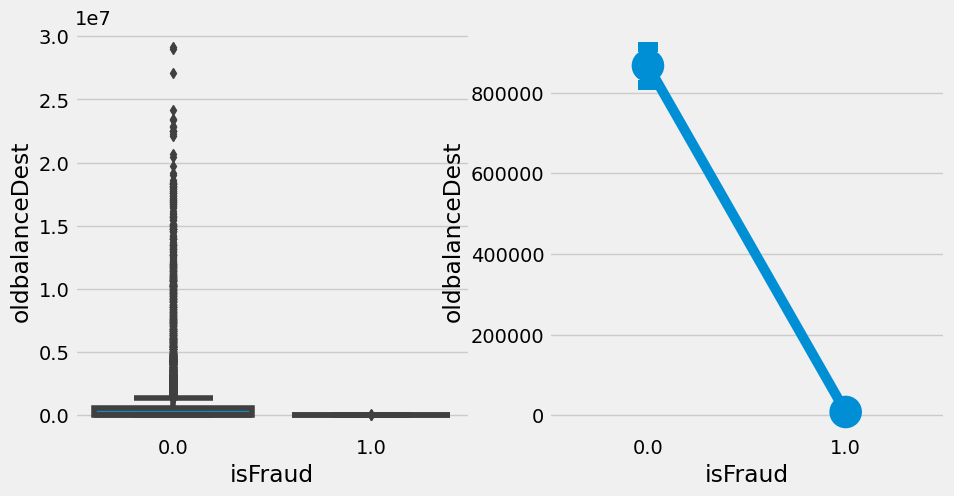

interval at column oldbalanceDest which gets accepted is between -4216.809843833016 and 21057.060613063786
interval at column oldbalanceDest which gets rejected is between 819088.7891350406 and 914491.2648911936
 
there is no difference between customers with Fraud and non-Fraud at feature oldbalanceDest
 
6. isFraud - newbalanceDest


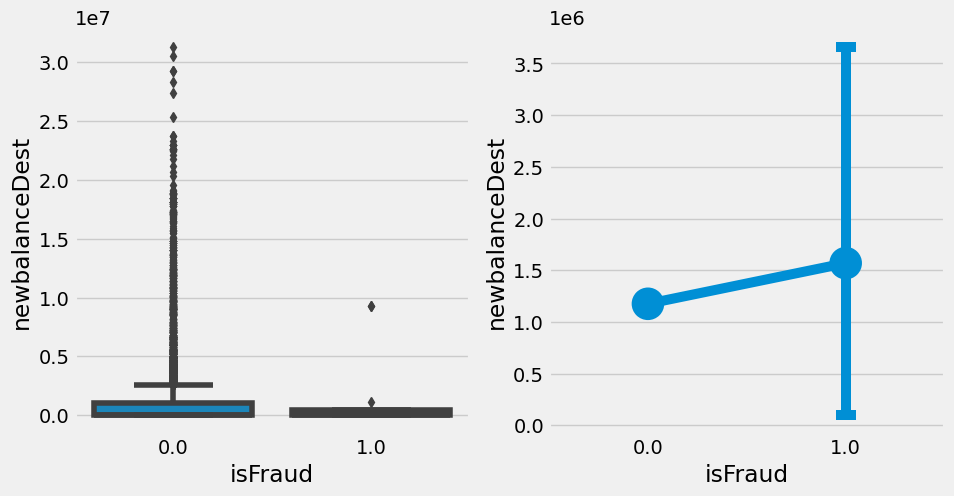

interval at column newbalanceDest which gets accepted is between -510935.3353385993 and 3648169.638415522
interval at column newbalanceDest which gets rejected is between 1119381.1425140589 and 1231374.6075229892
 
there is no difference between customers with Fraud and non-Fraud at feature newbalanceDest
 


In [ ]:
for num, col in enumerate(df2_num, 1):
    if col != 'isFraud':
        print(f'{num}. isFraud - {col}')
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        sns.boxplot(data=df2, x='isFraud', y=col, ax=ax[0])
        sns.pointplot(data=df2, x='isFraud', y=col, ax=ax[1], capsize=0.1)
        plt.show()

        # determine interval mean from 1 and 0 have same statistic in confidence level of 95%

        df2_na = df2.dropna()

        a = len(df2_na[df2_na['isFraud']==1])
        b = len(df2_na[df2_na['isFraud']==0])

        alpha = 0.05  # Significance level
        confidence = 1 - alpha  # Confidence level

        int1 = st.t.interval(confidence,
                             df=a-1,
                             loc=df2_na[df2_na['isFraud']==1][col].mean(),
                             scale=df2_na[df2_na['isFraud']==1][col].std()/(a**(1/2)))

        print(f'interval at column {col} which gets accepted is between {int1[0]} and {int1[1]}')

        int2 = st.t.interval(confidence,
                             df=b-1,
                             loc=df2_na[df2_na['isFraud']==0][col].mean(),
                             scale=df2_na[df2_na['isFraud']==0][col].std()/(b**(1/2)))

        print(f'interval at column {col} which gets rejected is between {int2[0]} and {int2[1]}')

        stats, pval = st.ttest_ind(df2_na[df2_na['isFraud']==1][col],
                                   df2_na[df2_na['isFraud']==0][col])
        print(' ')

        if pval > alpha:
            print(f'there is no difference between customers with Fraud and non-Fraud at feature {col}')
        else:
            print(f'there is a difference between customers with Fraud and non-Fraud at feature {col}')
        print(' ')

1.isFraud - type


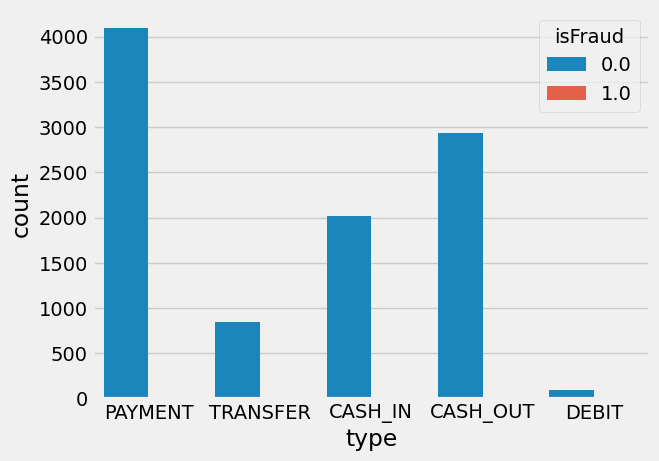

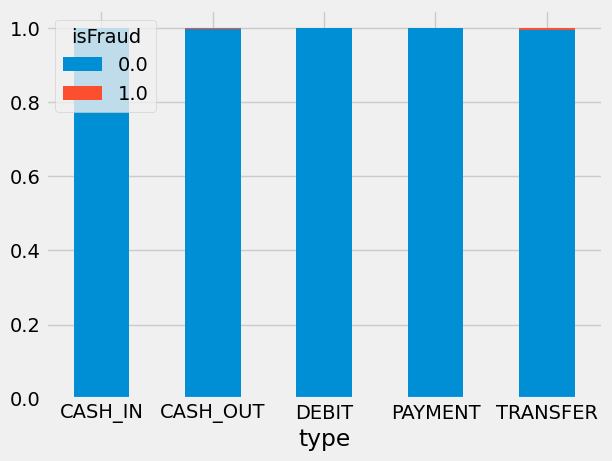

isFraud   0.0_total  1.0_total  0.0_percent  1.0_percent
type                                                    
CASH_IN        2016          0        100.0          0.0
CASH_OUT       2937          8        100.0          0.0
DEBIT           100          0        100.0          0.0
PAYMENT        4091          0        100.0          0.0
TRANSFER        843          5         99.0          1.0
--------------------------------------------------
 


In [ ]:
for num, col in enumerate(df2_cat,1):
    if col != 'isFraud':
        print(f'{num}.isFraud - {col}')
        sns.countplot(data=df2, x=col, hue='isFraud')
        plt.show()
        pd.crosstab(df2[col], df2['isFraud'], normalize='index').plot(kind='bar', stacked=True)
        plt.xticks(rotation=0)
        plt.show()
        a = pd.crosstab(df2[col], df2['isFraud'])
        b = pd.crosstab(df2[col], df2['isFraud'], normalize='index')
        c = a.join(round(b,2)*100, lsuffix='_total', rsuffix='_percent')
        print(c)
        print('-'*50)
        print(' ')

In [ ]:
X = df2.drop('isFraud', axis=1)
y = df2['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y,
                                                    test_size=0.2)

print(f'shape X_train: {X_train.shape}')
print(f'shape X_test: {X_test.shape}')
print(f'shape y_train: {y_train.shape}')
print(f'shape y_test: {y_test.shape}')

shape X_train: (8000, 7)
shape X_test: (2000, 7)
shape y_train: (8000,)
shape y_test: (2000,)


In [ ]:
def train_pre(X_train, X_test):
    X_train_enc = X_train.copy()
    X_num = X_train_enc.select_dtypes('number').columns
    X_cat = X_train_enc.select_dtypes('object').columns

    oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
    X_train_enc[X_cat] = oe.fit_transform(X_train_enc[X_cat])

    knn = KNNImputer(n_neighbors=5)
    X_train_imp = pd.DataFrame(knn.fit_transform(X_train_enc), columns=X_train_enc.columns)

    X_train_imp[X_cat] = oe.inverse_transform(X_train_imp[X_cat])

    ohe = OneHotEncoder(handle_unknown='ignore')
    X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train_imp[X_cat]).toarray(),
                               columns=ohe.get_feature_names_out(X_cat))

    ss = StandardScaler()
    X_train_ss = pd.DataFrame(ss.fit_transform(X_train_imp[X_num]),
                              columns= X_num)

    X_train_trans = pd.concat([X_train_ss, X_train_ohe], axis=1)

    X_test_enc = X_test.copy()

    X_test_enc[X_cat] = oe.transform(X_test_enc[X_cat])
    X_test_imp = pd.DataFrame(knn.transform(X_test_enc), columns=X_train_enc.columns)
    X_test_imp[X_cat] = oe.inverse_transform(X_test_imp[X_cat])
    X_test_ohe = pd.DataFrame(ohe.transform(X_test_imp[X_cat]).toarray(),
                               columns=ohe.get_feature_names_out(X_cat))
    X_test_ss = pd.DataFrame(ss.transform(X_test_imp[X_num]),
                              columns= X_num)
    X_test_trans = pd.concat([X_test_ss, X_test_ohe], axis=1)

    return X_train_trans, X_test_trans

In [ ]:
X_train_trans = train_pre(X_train, X_test)[0]
X_test_trans = train_pre(X_train, X_test)[1]

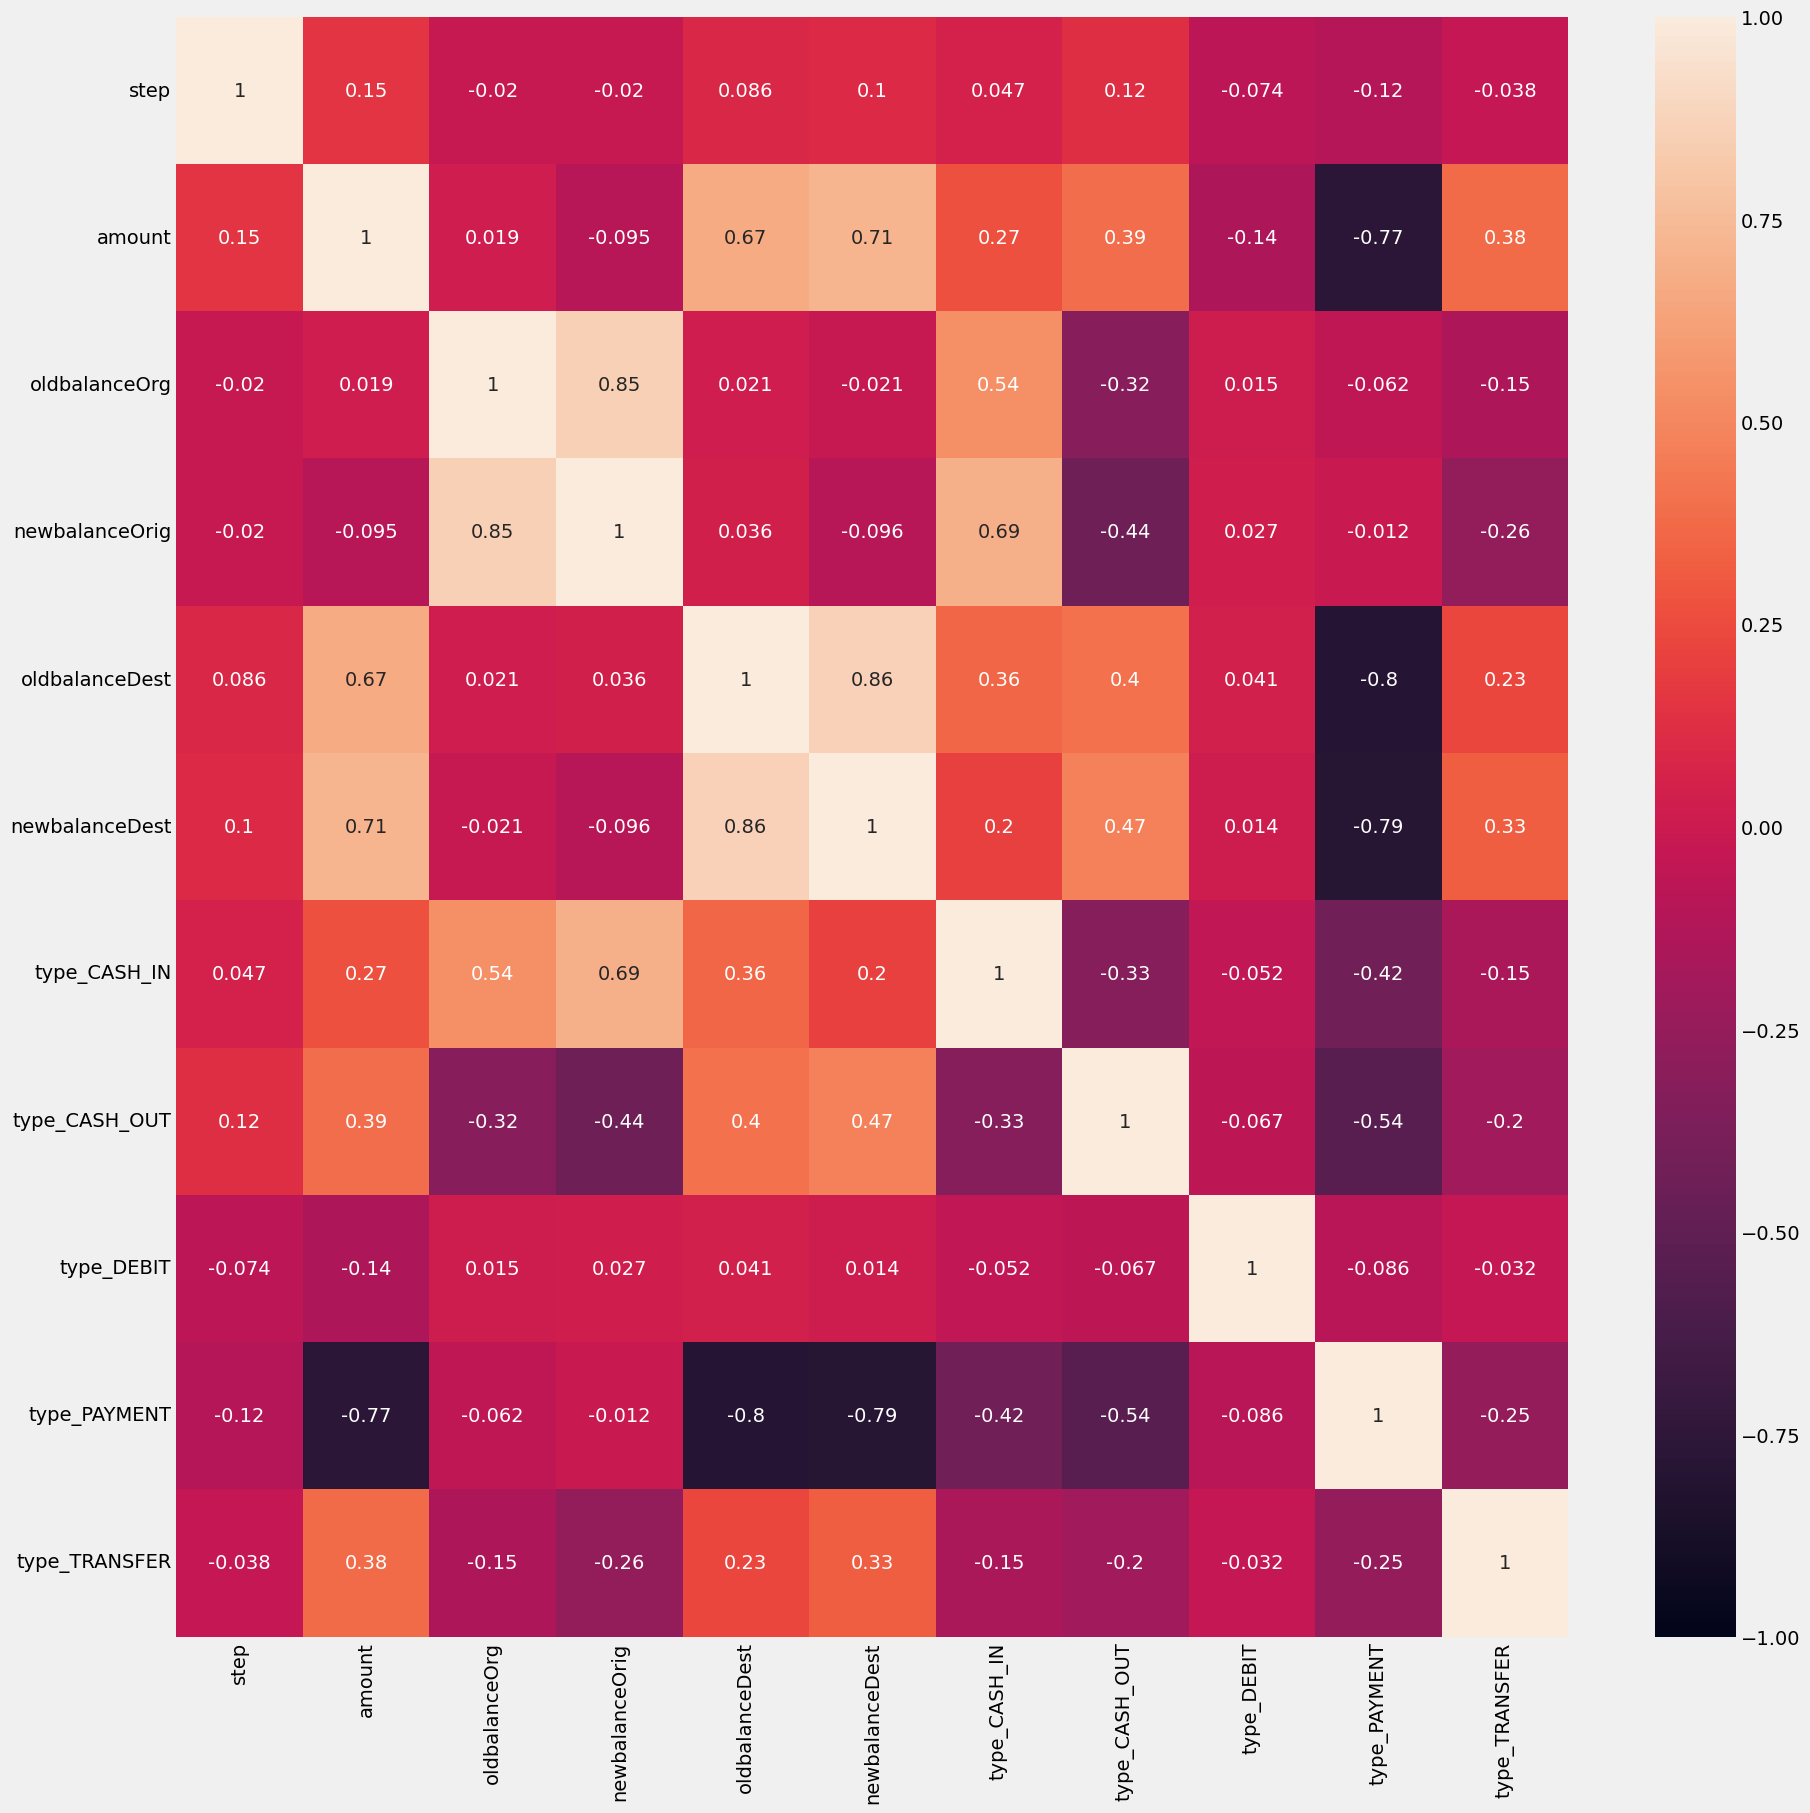

In [ ]:
plt.figure(figsize=(20,20))
corr = X_train_trans.corr(method='spearman')
sns.heatmap(corr,vmin=-1, vmax=1, annot=True)
plt.show()

In [ ]:
drop1 = []
drop2 = []
for col1, col2 in comb(X_train_trans, 2):
    koef, pval = st.spearmanr(X_train_trans[col1],
                             X_train_trans[col2])
    if (koef < -0.85) | (koef > 0.85):
        print(f'{col1} - {col2}')
        drop1.append(col1)
        drop2.append(col2)

print(' ')
print(drop1)
print(drop2)

oldbalanceOrg - newbalanceOrig
oldbalanceDest - newbalanceDest
 
['oldbalanceOrg', 'oldbalanceDest']
['newbalanceOrig', 'newbalanceDest']


In [ ]:
X_train_trans.drop(drop1, axis=1, inplace=True)
X_train_trans.head()

,step,amount,newbalanceOrig,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,-0.083686,-0.488758,-0.326610,-0.410059,0.0,0.0,0.0,1.0,0.0
1,0.437724,-0.068913,-0.328562,-0.336887,0.0,1.0,0.0,0.0,0.0
2,0.437724,1.618387,-0.328562,1.282220,0.0,1.0,0.0,0.0,0.0
3,0.437724,0.412238,-0.120927,-0.302070,0.0,1.0,0.0,0.0,0.0
4,0.959135,0.098838,0.664192,-0.309957,1.0,0.0,0.0,0.0,0.0


In [ ]:
mi_col = pd.DataFrame({'col': X_train_trans.columns,
                       'mi': mutual_info_classif(X_train_trans,y_train, random_state=42)}).sort_values('mi')

mi_col

,col,mi
1,amount,0.000000
6,type_DEBIT,0.000000
8,type_TRANSFER,0.000000
3,newbalanceDest,0.000079
4,type_CASH_IN,0.000767
5,type_CASH_OUT,0.001272
7,type_PAYMENT,0.001440
0,step,0.001547
2,newbalanceOrig,0.001692


In [ ]:
mi = mi_col[mi_col['mi'] > 0]['col']
mi

3    newbalanceDest
4      type_CASH_IN
5     type_CASH_OUT
7      type_PAYMENT
0              step
2    newbalanceOrig
Name: col, dtype: object

In [ ]:
X_train_trans = X_train_trans[mi]
X_train_trans.head()

,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_PAYMENT,step,newbalanceOrig
0,-0.410059,0.0,0.0,1.0,-0.083686,-0.326610
1,-0.336887,0.0,1.0,0.0,0.437724,-0.328562
2,1.282220,0.0,1.0,0.0,0.437724,-0.328562
3,-0.302070,0.0,1.0,0.0,0.437724,-0.120927
4,-0.309957,1.0,0.0,0.0,0.959135,0.664192


In [ ]:
X_test_trans = X_test_trans[X_train_trans.columns]
X_test_trans.head()

,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_PAYMENT,step,newbalanceOrig
0,6.152333,1.0,0.0,0.0,-0.083686,7.152528
1,-0.410059,0.0,0.0,1.0,-0.605097,-0.302730
2,-0.410059,0.0,0.0,1.0,0.437724,-0.328562
3,0.490340,0.0,1.0,0.0,0.437724,-0.328562
4,-0.410059,1.0,0.0,0.0,0.437724,4.652849


In [ ]:
logreg_def = LogisticRegression(random_state=42)
rf_def = RandomForestClassifier(random_state=42)
tree_def = DecisionTreeClassifier(random_state=42)
xgb_def = XGBClassifier(random_state=42)
knn_def = KNeighborsClassifier()
ada_def = AdaBoostClassifier(random_state=42)
svc_rbf_def = SVC(random_state=42, probability=True)
svc_poly_def = SVC(kernel='poly', random_state=42, probability=True)

In [ ]:
model_vot = []

model_vot.append(('lr', logreg_def))
model_vot.append(('xgb', xgb_def))
model_vot.append(('dt', tree_def))
vot_clas = VotingClassifier(model_vot, voting='soft')

model_lvl2 = logreg_def
stack_cla = StackingClassifier(model_vot, model_lvl2)

In [ ]:
model = [logreg_def, rf_def, tree_def, xgb_def, ada_def, svc_rbf_def, svc_poly_def, knn_def, vot_clas, stack_cla]
model_list = ['logreg_def', 'rf_def', 'tree_def', 'xgb_def', 'ada_def', 'svc_rbf_def', 'svc_poly_def', 'knn_def', 'vot_clas', 'stack_cla']

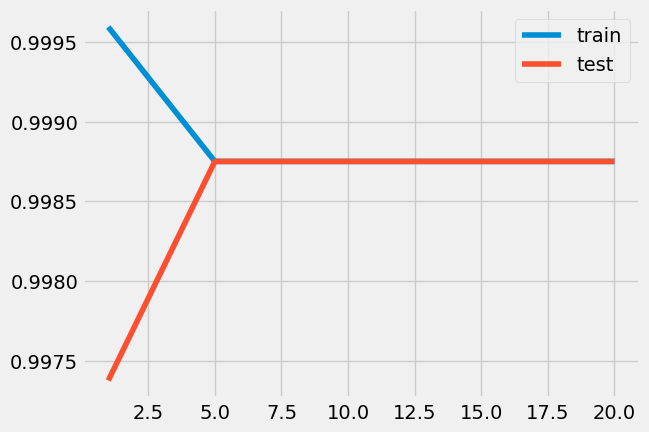

5

In [ ]:
x = [1,5,10,20]
train = []
test = []

for val in x:
    knn2 = KNeighborsClassifier(n_neighbors=val)
    cv = cross_validate(knn2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

In [ ]:
knn_tun = KNeighborsClassifier(n_neighbors=10)
model.append(knn_tun)
model_list.append('knn_tun')

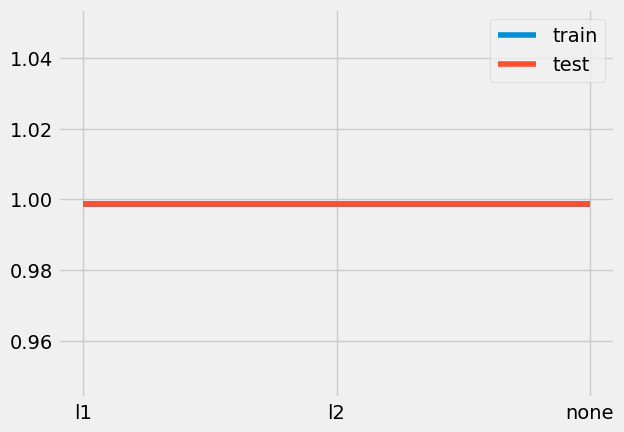

'l1'

In [ ]:
x = ['l1','l2','none']
train = []
test = []

for val in x:
    logreg2 = LogisticRegression(random_state=42,
                                 solver='saga',
                                 penalty=val)
    cv = cross_validate(logreg2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

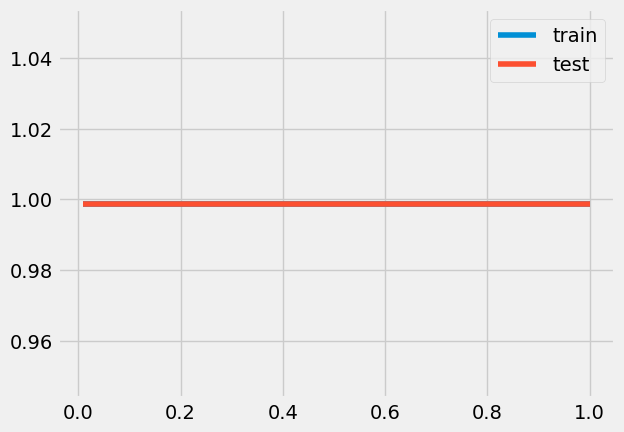

0.01

In [ ]:
x = [0.01,0.1,1]
train = []
test = []

for val in x:
    logreg2 = LogisticRegression(random_state=42,
                                 solver='saga',
                                 penalty='l1',
                                 C=val)
    cv = cross_validate(logreg2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

In [ ]:
logreg_tun = LogisticRegression(random_state=42,
                                 solver='saga',
                                 penalty='l1',
                                 C=0.01)
model.append(logreg_tun)
model_list.append('logreg_tun')

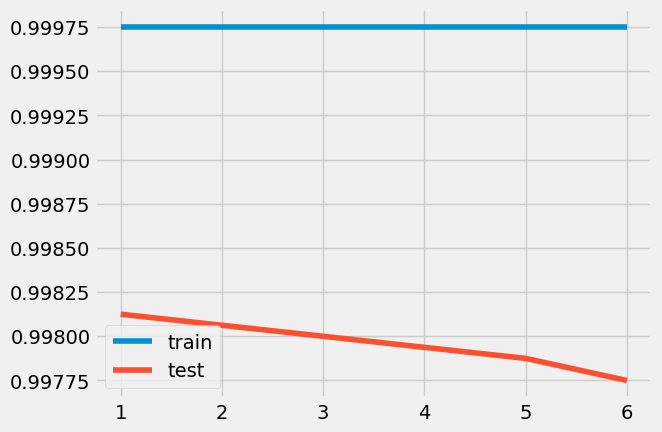

1

In [ ]:
x = [1,5,6]
train = []
test = []

for val in x:
    tree2 = DecisionTreeClassifier(random_state=42,
                                     max_features=val)
    cv = cross_validate(tree2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

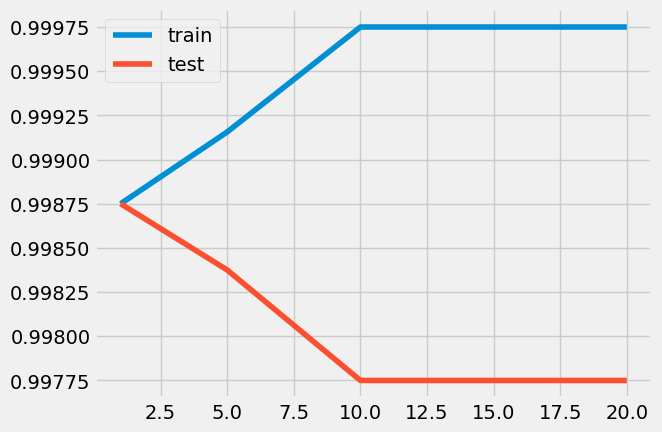

1

In [ ]:
x = [1,5,10,20]
train = []
test = []

for val in x:
    tree2 = DecisionTreeClassifier(random_state=42,
                                   max_features=6,
                                   max_depth=val)
    cv = cross_validate(tree2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]


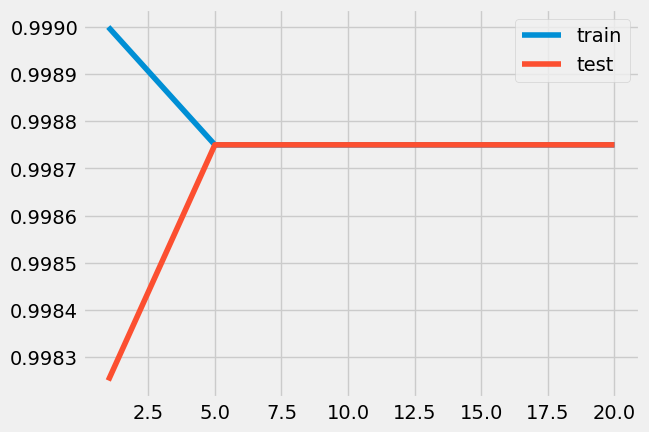

5

In [ ]:
x = [1,5,10,20]
train = []
test = []

for val in x:
    tree2 = DecisionTreeClassifier(random_state=42,
                                   max_features=6,
                                   max_depth=20,
                                   min_samples_split=20,
                                   min_samples_leaf=val)
    cv = cross_validate(tree2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

In [ ]:
tree_tun = DecisionTreeClassifier(random_state=42,
                                   max_features=6,
                                   max_depth=20,
                                   min_samples_split=20,
                                   min_samples_leaf=1,
                                   max_leaf_nodes=20)

model.append(tree_tun)
model_list.append('tree_tun')

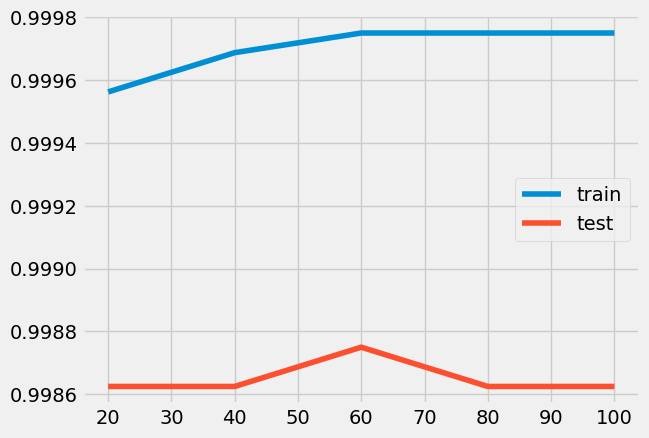

60

In [ ]:
x = [20,40,60,80,100]
train = []
test = []

for val in x:
    rf2 = RandomForestClassifier(random_state=42,
                                 n_estimators=val)
    cv = cross_validate(rf2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

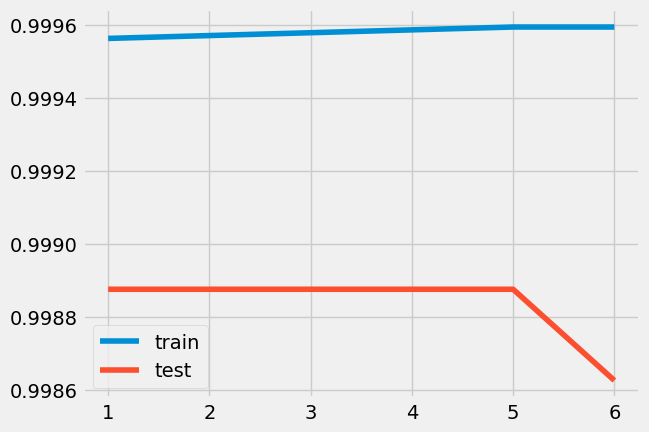

1

In [ ]:
x = [1,5,6]
train = []
test = []

for val in x:
    rf2 = RandomForestClassifier(random_state=42,
                                 n_estimators=20,
                                 max_features=val)
    cv = cross_validate(rf2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

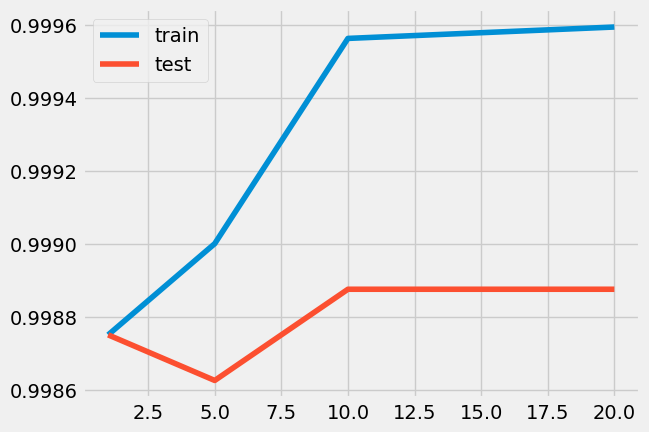

10

In [ ]:
x = [1,5,10,20]
train = []
test = []

for val in x:
    rf2 = RandomForestClassifier(random_state=42,
                                 n_estimators=20,
                                 max_features=5,
                                 max_depth=val)
    cv = cross_validate(rf2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

In [ ]:
rf_tun = RandomForestClassifier(random_state=42,
                                 n_estimators=20,
                                 max_features=5,
                                 max_depth=20,
                                 min_samples_split=20,
                                 min_samples_leaf=20)
model.append(rf_tun)
model_list.append('rf_tun')

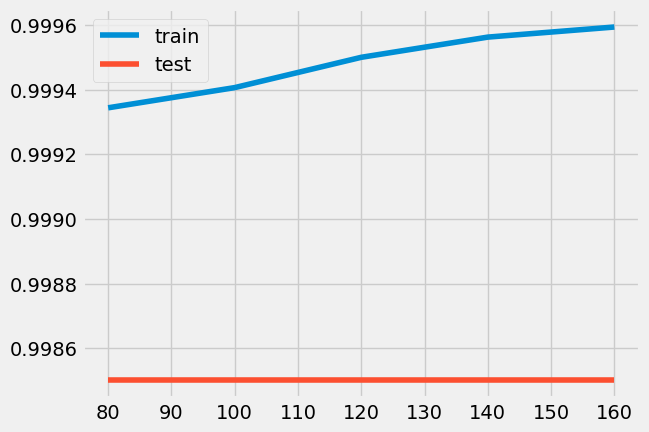

80

In [ ]:
x = [80,100,120,140,160]
train = []
test = []

for val in x:
    xgb2 = XGBClassifier(random_state=42,
                        n_estimators=val)
    cv = cross_validate(xgb2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

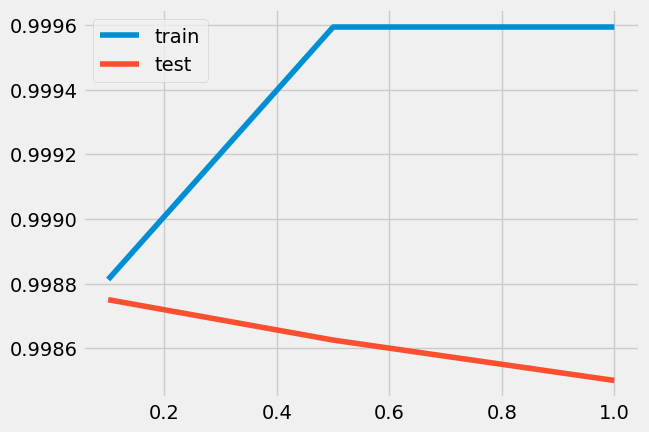

0.1

In [ ]:
x = [0.1, 0.5, 1]
train = []
test = []

for val in x:
    xgb2 = XGBClassifier(random_state=42,
                         n_estimators=80,
                         learning_rate=val)
    cv = cross_validate(xgb2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]


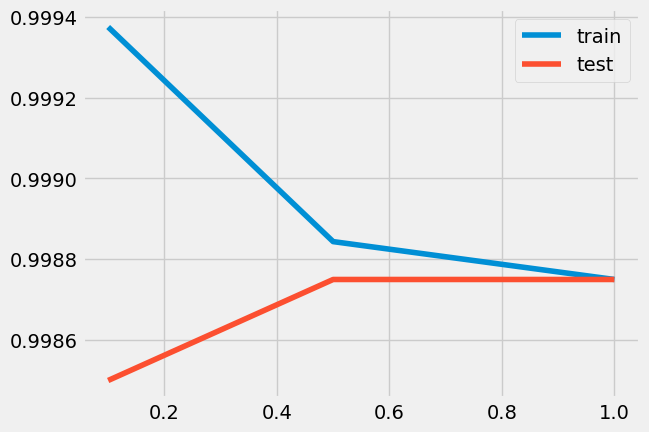

0.5

In [ ]:
x = [0.1, 0.5, 1]
train = []
test = []

for val in x:
    xgb2 = XGBClassifier(random_state=42,
                         n_estimators=80,
                         learning_rate=0.5,
                         gamma=val)
    cv = cross_validate(xgb2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

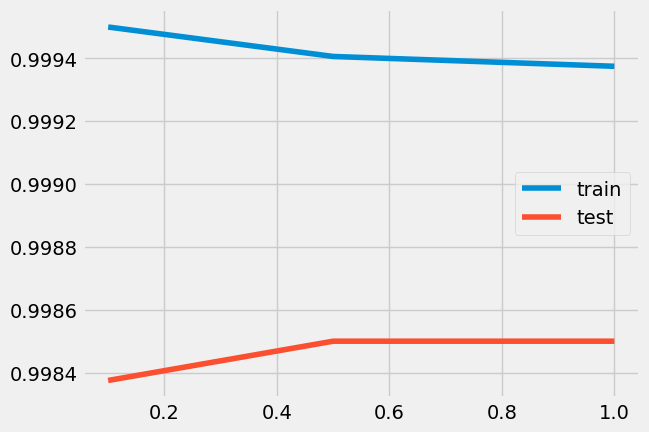

0.5

In [ ]:
x = [0.1,0.5,1]
train = []
test = []

for val in x:
    xgb2 = XGBClassifier(random_state=42,
                         n_estimators=80,
                         learning_rate=0.5,
                         gamma=0.1,
                         reg_lambda=val)
    cv = cross_validate(xgb2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

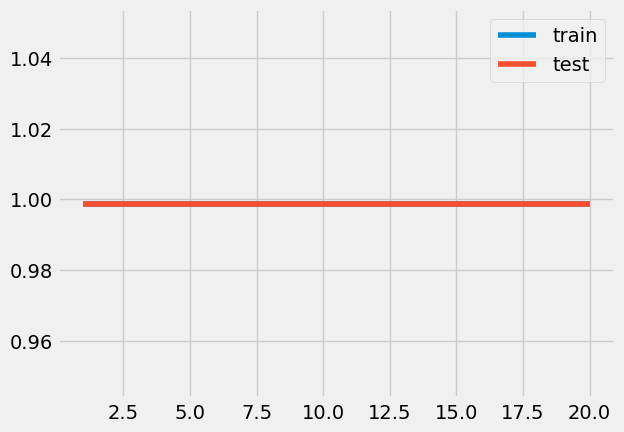

1

In [ ]:
x = [1,5,10,20]
train = []
test = []

for val in x:
    xgb2 = XGBClassifier(random_state=42,
                         n_estimators=5,
                         learning_rate=0.5,
                         gamma=0.5,
                         reg_lambda=0.1,
                         max_depth=val)
    cv = cross_validate(xgb2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

In [ ]:
xgb_tun = XGBClassifier(random_state=42,
                         n_estimators=80,
                         learning_rate=0.5,
                         gamma=0.1,
                         reg_lambda=0.1,
                         max_depth=20)
model.append(xgb_tun)
model_list.append('xgb_tun')

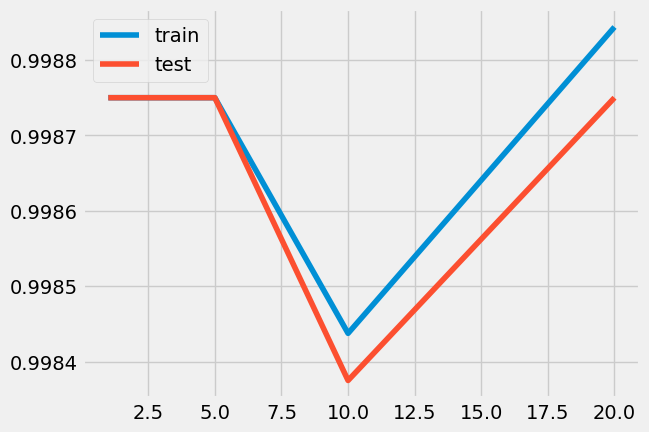

1

In [ ]:
x = [1,5,10,20]
train = []
test = []

for val in x:
    ada2 = AdaBoostClassifier(random_state=42,
                              n_estimators=val)
    cv = cross_validate(ada2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

In [ ]:
x = [0.1,0.5,1]
train = []
test = []

for val in x:
    ada2 = AdaBoostClassifier(random_state=42,
                              n_estimators=10,
                              learning_rate=val)
    cv = cross_validate(ada2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

In [ ]:
ada_tun = AdaBoostClassifier(random_state=42,
                              n_estimators=10,
                              learning_rate=1)
model.append(ada_tun)
model_list.append('ada_tun')

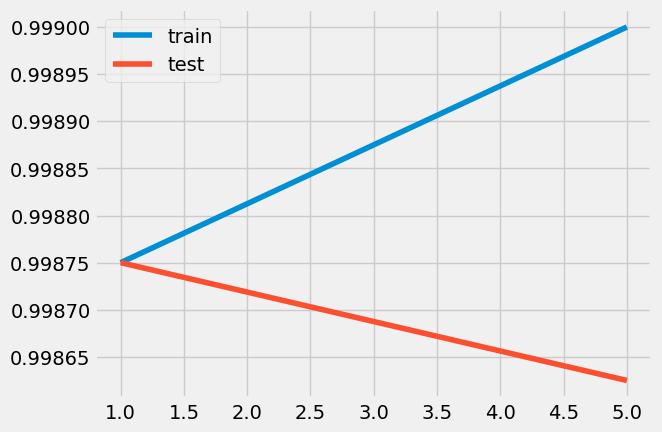

1

In [ ]:
x = [1,5]
train = []
test = []

for val in x:
    poly = SVC(kernel='poly',
               random_state=42,
               degree=val)
    cv = cross_validate(poly, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

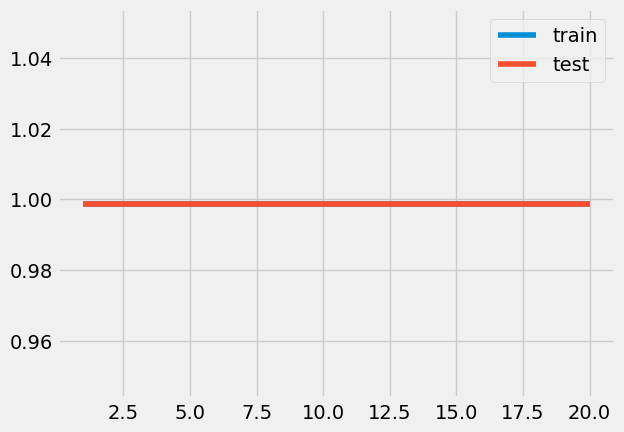

1

In [ ]:
x = [1,5,10,20]
train = []
test = []

for val in x:
    poly = SVC(kernel='poly',
               random_state=42,
               degree=1,
               C=val)
    cv = cross_validate(poly, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

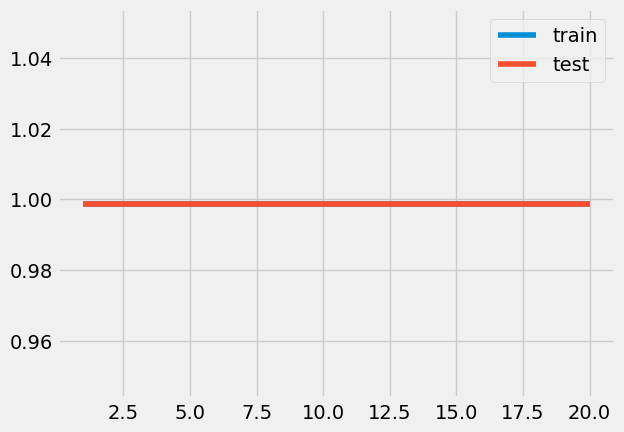

1

In [ ]:
x = [1,5,10,20]
train = []
test = []

for val in x:
    poly = SVC(kernel='poly',
               random_state=42,
               degree=1,
               C=1,
               coef0=val)
    cv = cross_validate(poly, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

In [ ]:
svc_poly_tun = SVC(kernel='poly',
                   random_state=42,
                   degree=1,
                   C=1,
                   coef0=1,
                   probability=True)

model.append(svc_poly_tun)
model_list.append('svc_poly_tun')

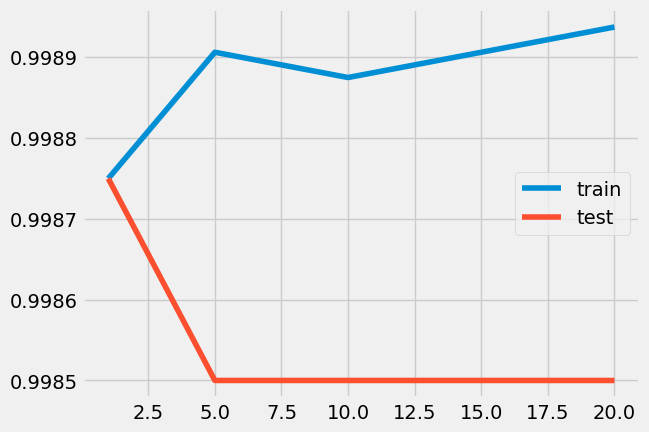

1

In [ ]:
x = [1,5,10,20]
train = []
test = []

for val in x:
    poly = SVC(kernel='rbf',
               random_state=42,
               C=val)
    cv = cross_validate(poly, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

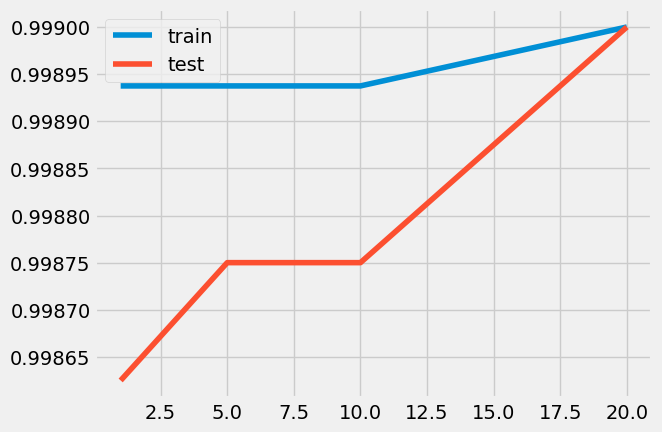

20

In [ ]:
x = [1,5,10,20]
train = []
test = []

for val in x:
    poly = SVC(kernel='rbf',
               random_state=42,
               C=1,
               gamma=val)
    cv = cross_validate(poly, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

In [ ]:
svc_rbf_tun = SVC(kernel='rbf',
                   random_state=42,
                   C=1,
                   gamma=1,
                   probability=True)

model.append(svc_rbf_tun)
model_list.append('svc_rbf_tun')

In [ ]:
model_vot_tun = []

model_vot_tun.append(('lr', logreg_tun))
model_vot_tun.append(('xgb', xgb_tun))
model_vot_tun.append(('dt', tree_tun))
vot_clas_tun = VotingClassifier(model_vot_tun, voting='soft')

model_lvl2_tun = logreg_tun
stack_cla_tun = StackingClassifier(model_vot_tun, model_lvl2_tun)

model.append(vot_clas_tun)
model_list.append('vot_clas_tun')

model.append(stack_cla_tun)
model_list.append('stack_cla_tun')

In [ ]:
score = {'model': [],
         'roc': [],
         'acc': [],
         'recall': [],
         'NPV': []}

for mod, mods in zip(model, model_list):
    for y in ['_test','_train']:
        if y == '_test':
            mod.fit(X_train_trans, y_train)
            score['model'].append(mods+y)
            tn, fp, fn, tp = confusion_matrix(y_test, mod.predict(X_test_trans)).ravel()
            score['roc'].append(roc_auc_score(y_test, mod.predict_proba(X_test_trans)[:,1]))
            score['recall'].append(recall_score(y_train, mod.predict(X_train_trans)))
            score['acc'].append(accuracy_score(y_test, mod.predict(X_test_trans)))
            score['NPV'].append(tn/(tn+fn))

        elif y =='_train':
            mod.fit(X_train_trans, y_train)
            score['model'].append(mods+y)
            tn, fp, fn, tp = confusion_matrix(y_train, mod.predict(X_train_trans)).ravel()
            score['roc'].append(roc_auc_score(y_train, mod.predict_proba(X_train_trans)[:,1]))
            score['acc'].append(accuracy_score(y_train, mod.predict(X_train_trans)))
            score['recall'].append(recall_score(y_train, mod.predict(X_train_trans)))
            score['NPV'].append(tn/(tn+fn))

pd.DataFrame(score).sort_values(['roc','acc','NPV'], ascending=False)

,model,roc,acc,recall,NPV
5,tree_def_train,0.999437,0.999750,0.8,0.999750
19,stack_cla_train,0.999412,0.998750,0.0,0.998750
3,rf_def_train,0.999111,0.999750,0.8,0.999750
37,vot_clas_tun_train,0.999099,0.998875,0.1,0.998875
9,ada_def_train,0.998648,0.999250,0.4,0.999250
25,tree_tun_train,0.998636,0.998875,0.1,0.998875
17,vot_clas_train,0.998060,0.999625,0.7,0.999625
29,xgb_tun_train,0.998054,0.999625,0.8,0.999750
7,xgb_def_train,0.997566,0.999500,0.7,0.999625
8,ada_def_test,0.995660,0.998500,0.4,0.998500
